#**Data Preparation**




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time
import datetime
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pandas_datareader as pdr
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.graph_objects as go 
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

In [ ]:
ticker = '^GSPC'
period1 = int(time.mktime(datetime.datetime(2016, 10, 31, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2021, 10, 31, 23, 59).timetuple()))
interval = '1d'

def getHistoricalData(ticker):
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

    df = pd.read_csv(query_string)
    return df

In [ ]:
df = getHistoricalData(ticker)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-10-31,2129.780029,2133.250000,2125.530029,2126.149902,2126.149902,3922400000
1,2016-11-01,2128.679932,2131.449951,2097.850098,2111.719971,2111.719971,4532160000
2,2016-11-02,2109.429932,2111.760010,2094.000000,2097.939941,2097.939941,4248580000
3,2016-11-03,2098.800049,2102.560059,2085.229980,2088.659912,2088.659912,3886740000
4,2016-11-04,2083.790039,2099.070068,2083.790039,2085.179932,2085.179932,3837860000
...,...,...,...,...,...,...,...
1254,2021-10-25,4553.689941,4572.620117,4537.359863,4566.479980,4566.479980,3250210000
1255,2021-10-26,4578.689941,4598.529785,4569.169922,4574.790039,4574.790039,2866500000
1256,2021-10-27,4580.220215,4584.569824,4551.660156,4551.680176,4551.680176,3259510000
1257,2021-10-28,4562.839844,4597.549805,4562.839844,4596.419922,4596.419922,3197560000


In [ ]:
df['Date'].isnull().describe()

count      1259
unique        1
top       False
freq       1259
Name: Date, dtype: object

In [ ]:
df['Open'].isnull().describe()

count      1259
unique        1
top       False
freq       1259
Name: Open, dtype: object

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

avg_open = df.groupby(['Date']).sum()['Open']
display(avg_open)

Date
2016-10-31    2129.780029
2016-11-01    2128.679932
2016-11-02    2109.429932
2016-11-03    2098.800049
2016-11-04    2083.790039
                 ...     
2021-10-25    4553.689941
2021-10-26    4578.689941
2021-10-27    4580.220215
2021-10-28    4562.839844
2021-10-29    4572.870117
Name: Open, Length: 1259, dtype: float64

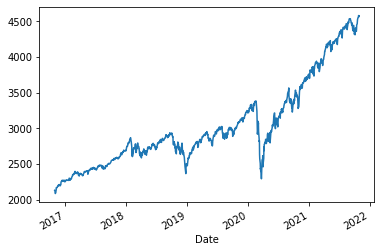

In [ ]:
avg_open.plot()

#**Split to Train Test**

In [ ]:
avg_open = avg_open.reset_index()
avg_open.head(5)

,Date,Open
0,2016-10-31,2129.780029
1,2016-11-01,2128.679932
2,2016-11-02,2109.429932
3,2016-11-03,2098.800049
4,2016-11-04,2083.790039


In [ ]:
#define x and y
# x axis use index to traverse
X = np.array([i for i in range(0,len(avg_open))])
Y = np.array(avg_open['Open'])

#Split into Train and Test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,train_size = 0.7, random_state = 42)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 42)

In [ ]:
X

array([   0,    1,    2, ..., 1256, 1257, 1258])

In [ ]:
Y

array([2129.780029, 2128.679932, 2109.429932, ..., 4580.220215,
       4562.839844, 4572.870117])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_normalized = scaler.fit_transform(np.array([Y]).T)

In [ ]:
X_normalized

array([[0.0184223 ],
       [0.01798163],
       [0.01027062],
       ...,
       [1.        ],
       [0.99303791],
       [0.99705576]])

#**Curve Fit**

In [ ]:
#define linear function
def f1(x,a,b):
  return a*x+b

In [ ]:
#apply and use curve fit
t,_ = curve_fit(f1, X_train, Y_train)
X_output = np.array(X)
Y_output = f1(X_output, t[0], t[1])

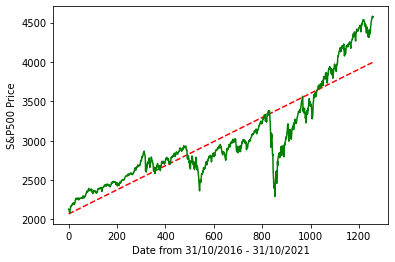

In [ ]:
#plot the graph
plt.plot(X_output,Y_output,'r--', label = 'Predicted S&P500 Price')
plt.plot(X,Y,'g', label = 'Actual Price')
plt.xlabel('Date from 31/10/2016 - 31/10/2021'); 
plt.ylabel('S&P500 Price')
plt.show()

In [ ]:
Y_predicted = f1(X_test,t[0],t[1])
MSEcf = mean_squared_error(Y_test, Y_predicted)
RMSEcf = np.sqrt(MSEcf)
MAEcf = mean_absolute_error(Y_test, Y_predicted)
R2cf = r2_score(Y_test, Y_predicted)



print('MSE:', MSEcf)
print('RMSE:', RMSEcf)
print('MAE:', MAEcf)
print('R²:', R2cf)

MSE: 68484.04023070332
RMSE: 261.69455521791684
MAE: 203.39874010604169
R²: 0.8164081666613736


#**Decision Tree Regressor**

In [ ]:
dfLR  = df[['Open']]
dfLR

,Open
0,2129.780029
1,2128.679932
2,2109.429932
3,2098.800049
4,2083.790039
...,...
1254,4553.689941
1255,4578.689941
1256,4580.220215
1257,4562.839844


In [ ]:
future = 5
dfLR['Predict'] = dfLR[['Open']].shift(-future)
dfLR

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,Predict
0,2129.780029,2100.590088
1,2128.679932,2129.919922
2,2109.429932,2131.560059
3,2098.800049,2167.489990
4,2083.790039,2162.709961
...,...,...
1254,4553.689941,NaN
1255,4578.689941,NaN
1256,4580.220215,NaN
1257,4562.839844,NaN


In [ ]:
Xlr = np.array(dfLR.drop(['Predict'],1))[:-future]
Xlr

array([[2129.780029],
       [2128.679932],
       [2109.429932],
       ...,
       [4524.419922],
       [4532.240234],
       [4546.120117]])

In [ ]:
Ylr = np.array(dfLR['Predict'])[:-future]
Ylr

array([2100.590088, 2129.919922, 2131.560059, ..., 4580.220215,
       4562.839844, 4572.870117])

In [ ]:
Xlr_train, Xlr_test, Ylr_train, Ylr_test = train_test_split(Xlr, Ylr, test_size = 0.25)

In [ ]:
tree = DecisionTreeRegressor().fit(Xlr_train,Ylr_train)

In [ ]:
tree_predict = tree.predict(Xlr)

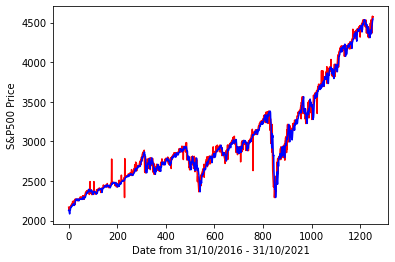

In [ ]:
plt.plot(tree_predict,'r', label = 'Predicted S&P500 Price')
plt.plot(Xlr,'b', label = 'Actual Price')
plt.xlabel('Date from 31/10/2016 - 31/10/2021'); 
plt.ylabel('S&P500 Price')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MSElr = mean_squared_error(Xlr, tree_predict)
RMSElr = np.sqrt(MSElr)
MAElr = mean_absolute_error(Xlr, tree_predict)
R2lr = r2_score(Xlr, tree_predict)

print('MSE:', MSElr)
print('RMSE:', RMSElr)
print('MAE:', MAElr)
print('R²:', R2lr)

MSE: 4648.49768871858
RMSE: 68.17989211430728
MAE: 46.22348340191387
R²: 0.9874640682090601


# **LSTM**

In [ ]:
X_train=X_normalized[:-1]
Y_train=X_normalized[1:]

In [ ]:
X_train[:5]

array([[0.0184223 ],
       [0.01798163],
       [0.01027062],
       [0.00601259],
       [0.        ]])

In [ ]:
Y_train[:5]

array([[0.01798163],
       [0.01027062],
       [0.00601259],
       [0.        ],
       [0.00672963]])

In [ ]:
ind=np.arange(5)
ind=np.arange(X.shape[0]-5).reshape(X.shape[0]-5,1)+ind
X_train=X_normalized[ind]
X_train=X_train.reshape((X_train.shape[0],1,X_train.shape[1]))

In [ ]:
X_train
Y_train=X_train[:,:,0][1:,:]
X_train=X_train[:-1,:,:]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout
from keras.layers import SpatialDropout1D
from tensorflow.keras import activations

model = Sequential()
model.add(LSTM(16, input_shape=(1,5)))
model.add(Dense(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
epochs = 50
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)


Epoch 1/50
20/20 [==============================] - 5s 5ms/step - loss: 0.1693
Epoch 2/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0883
Epoch 3/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 6/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 7/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 8/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 9/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 10/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 11/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 12/50
20/20 [==============================] - 0s 6ms/step - loss: 6.4985e-04
Epoch 13/50
20/20 [==========================

In [ ]:
Y_show=model.predict(X_train)

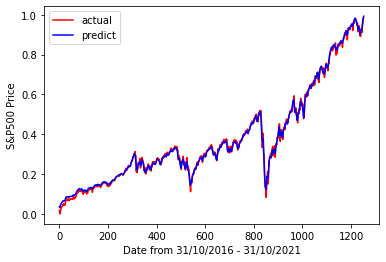

In [ ]:
plt.plot(Y_train,'r', label = 'Actual Price')
plt.plot(Y_show,'b', label = 'Predicted S&P500 Price')
plt.xlabel('Date from 31/10/2016 - 31/10/2021'); 
plt.ylabel('S&P500 Price')
plt.legend(['actual','predict'])
plt.show()

In [ ]:
#Score of the result
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MSElstm = mean_squared_error(Y_train, Y_show)
RMSElstm = np.sqrt(MSElstm)
MAElstm = mean_absolute_error(Y_train, Y_show)
R2lstm = r2_score(Y_train, Y_show)

print('MSE:', MSElstm)
print('RMSE:', RMSElstm)
print('MAE:', MAElstm)
print('R²:', R2lstm)

MSE: 0.00010390705009089909
RMSE: 0.01019348076423844
MAE: 0.007610512785275504
R²: 0.9982520086330954


#**Results**

In [ ]:
#Create DataFrame For Results
fin = {'Name':['MSE','RMSE','MAE','R2'],
       'Curve Fit':[MSEcf,RMSEcf,MAEcf,R2cf],
       'Decision Tree Regressor':[MSElr,RMSElr,MAElr,R2lr],
       'LSTM':[MSElstm,RMSElstm,MAElstm,R2lstm]}


res = pd.DataFrame(fin)
res

,Name,Curve Fit,Decision Tree Regressor,LSTM
0,MSE,68484.040231,4648.497689,0.000104
1,RMSE,261.694555,68.179892,0.010193
2,MAE,203.398740,46.223483,0.007611
3,R2,0.816408,0.987464,0.998252
